In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.special import erf
import pandas as pd

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [35]:
def prepare_mother_list(filepath, make_plot=True):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'dmJ', 'tau21J2']
    data.set_index('Event', inplace=True)
    
    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data) | (data==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    print('read array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.show()

    return data

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv):
    window = (list_by_minv.mJJ >= (M-3*deltaM)) & (list_by_minv.mJJ <= (M+3*deltaM))
    window = list_by_minv[window]
    SR = (window.mJJ > (M-deltaM)) & (window.mJJ < (M+deltaM))
    SR_masses = window[SR].mJJ.values

    #put the data on a unit hypercube and remove the edges
    hypercubemargin = 1e-10
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    window = (window - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # shrink to margin
    window = window * (1-2*hypercubemargin) + hypercubemargin
    # window.where(window > hypercubemargin, window + 1e-16, inplace=True)
    # window.where(window < 1 - hypercubemargin, window - 1e-16, inplace=True)
    
    SB = window[~SR].copy()
    SR = window[SR].copy()
    return tf.convert_to_tensor(SB.values), tf.convert_to_tensor(SR.values), SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg])
    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal')
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background')
            if i == 0:
                axs[divmod(i, 3)].legend()
        plt.tight_layout()
        plt.show()
    
    return combined

In [3]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [4]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [5]:
print(binary_masks(4))
np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]]


array([[0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.]])

In [6]:
def build_iflow(ndims,lr):
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=16,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(lr, clipnorm=10.0#, amsgrad=True
                                        )
    return dist, optimizer

In [7]:
@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [8]:
def save_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/model_layer_{:02d}'.format(j))

def load_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/model_layer_{:02d}'.format(j))
    print("Model loaded successfully")

In [9]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,lr=1e-3,epochs=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM,list_by_minv)
   
    if issig:
        data_train = sig
    else:
        data_train = bkg
        
    (totalpts, ndims) = np.shape(data_train)
    print(totalpts)
    
    dist, optimizer = build_iflow(ndims,lr) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize)
    print(batches)
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    for epoch in range(epochs+1):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches+1):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e}'.format(batch, loss))
        if epoch % 1 == 0:
            print('Epoch: {:3d} Loss = {:8e}'.format(epoch, loss))
    save_weights(dist)
    return dist

Import Data

read array of shape (999668, 5)
            mJJ       mJ1   tau21J1       dmJ   tau21J2
Event                                                  
450885  1132.28  256.4420  0.584751  122.0150  0.721372
900271  1344.41  136.4530  0.656294   45.9379  0.778359
606527  1356.00  221.5270  0.348195   17.9149  0.791087
618345  1359.23   66.5476  0.586281  100.3800  0.413897
602321  1369.24  153.4330  0.509714   16.0895  0.653790


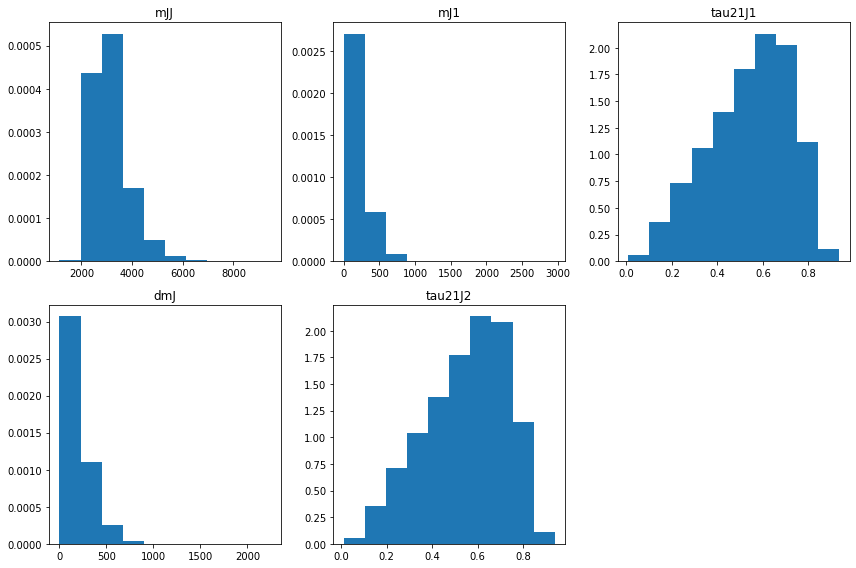

read array of shape (99948, 5)
           mJJ       mJ1   tau21J1       dmJ   tau21J2
Event                                                 
61569  1640.86  231.3330  0.468651   61.7481  0.801618
12978  1700.06  104.3390  0.156207   95.4028  0.565405
845    1703.78  116.1400  0.318631   55.2056  0.430425
69763  1718.81  113.0020  0.467825  102.3100  0.778852
821    1748.70   94.0819  0.437161   39.1778  0.657479


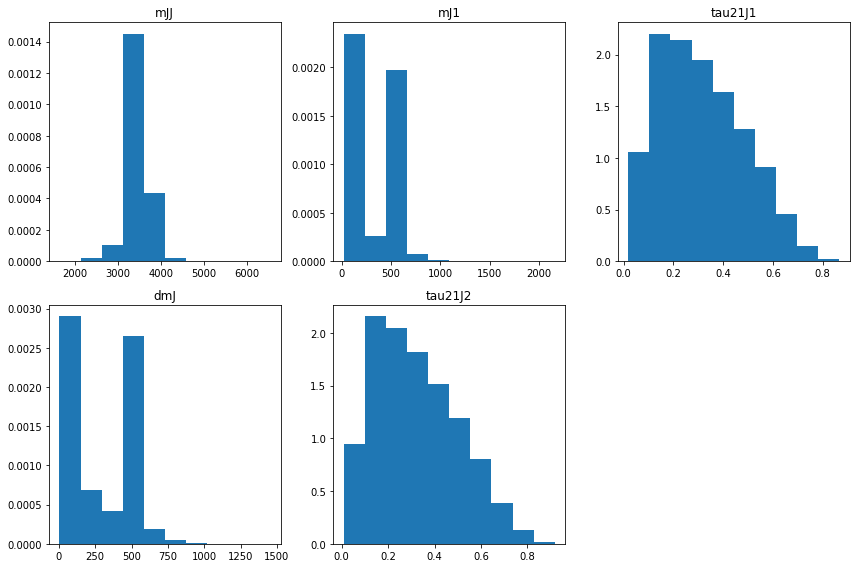

In [10]:
bkgname="rndbkgout.txt"
signame="rndsigout.txt"
bkglist=prepare_mother_list(bkgname)
siglist=prepare_mother_list(signame)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


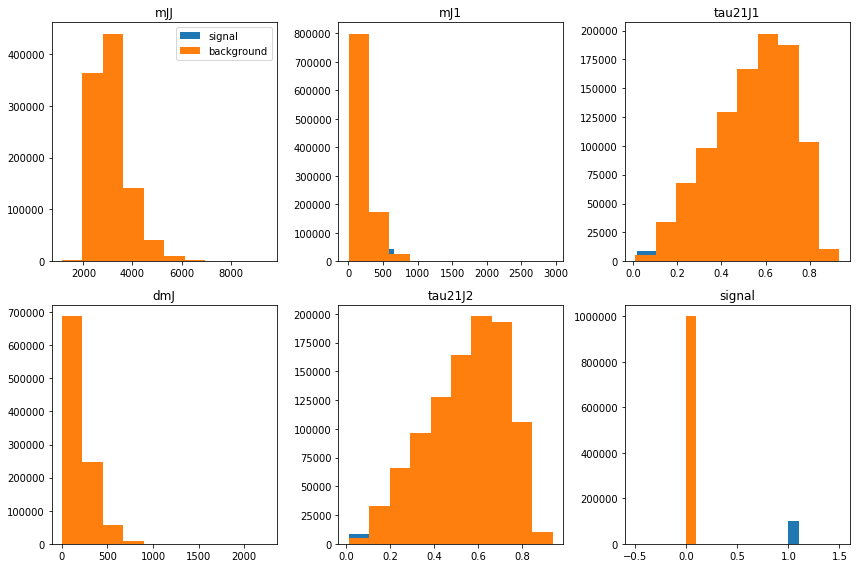

In [11]:
combined = combine_sig_bkg(siglist, bkglist)

Train on Signal Data

In [ ]:
sigdist =train_iflow(combined.drop(columns='signal') ,M=3800, deltaM=100,
                     issig=True, batchsize=256,lr=1e-3,epochs=50)

52856
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                

Batch:  30 Loss = -3.832687e+00
Batch:  40 Loss = -3.558501e+00
Batch:  50 Loss = -3.887471e+00
Batch:  60 Loss = -3.778839e+00
Batch:  70 Loss = -3.860070e+00
Batch:  80 Loss = -3.830804e+00
Batch:  90 Loss = -3.856878e+00
Batch: 100 Loss = -3.836820e+00
Batch: 110 Loss = -3.844666e+00
Batch: 120 Loss = -3.840928e+00
Batch: 130 Loss = -3.596314e+00
Batch: 140 Loss = -3.740465e+00
Batch: 150 Loss = -3.773080e+00
Batch: 160 Loss = -3.738423e+00
Batch: 170 Loss = -3.876286e+00
Batch: 180 Loss = -3.796889e+00
Batch: 190 Loss = -3.751970e+00
Batch: 200 Loss = -3.736916e+00
Epoch:   2 Loss = -3.674561e+00
Batch:   0 Loss = -3.653451e+00
Batch:  10 Loss = -3.793769e+00
Batch:  20 Loss = -3.686456e+00
Batch:  30 Loss = -3.895039e+00
Batch:  40 Loss = -3.703396e+00
Batch:  50 Loss = -3.724142e+00
Batch:  60 Loss = -3.909502e+00
Batch:  70 Loss = -3.926738e+00
Batch:  80 Loss = -3.820380e+00
Batch:  90 Loss = -3.785139e+00
Batch: 100 Loss = -3.782230e+00
Batch: 110 Loss = -3.746245e+00
Batch: 1

Batch: 180 Loss = -3.963778e+00
Batch: 190 Loss = -3.843461e+00
Batch: 200 Loss = -3.913529e+00
Epoch:  13 Loss = -3.579695e+00
Batch:   0 Loss = -3.967966e+00
Batch:  10 Loss = -3.777589e+00
Batch:  20 Loss = -3.799096e+00
Batch:  30 Loss = -3.890258e+00
Batch:  40 Loss = -3.857911e+00
Batch:  50 Loss = -3.952249e+00
Batch:  60 Loss = -3.724516e+00
Batch:  70 Loss = -3.798931e+00
Batch:  80 Loss = -3.861651e+00
Batch:  90 Loss = -3.768733e+00
Batch: 100 Loss = -3.803096e+00
Batch: 110 Loss = -3.769617e+00
Batch: 120 Loss = -4.013269e+00
Batch: 130 Loss = -3.935318e+00
Batch: 140 Loss = -3.895555e+00
Batch: 150 Loss = -3.764868e+00
Batch: 160 Loss = -3.903961e+00
Batch: 170 Loss = -3.930740e+00
Batch: 180 Loss = -3.942831e+00
Batch: 190 Loss = -3.847974e+00
Batch: 200 Loss = -3.797173e+00
Epoch:  14 Loss = -3.793003e+00
Batch:   0 Loss = -3.856458e+00
Batch:  10 Loss = -3.922992e+00
Batch:  20 Loss = -3.802578e+00
Batch:  30 Loss = -3.805944e+00
Batch:  40 Loss = -3.992269e+00
Batch:  

Train on Background Data

In [ ]:
bkgdist = train_iflow(combined.drop(columns='signal') ,M=3800, deltaM=100,
                      issig=False, batchsize=256,lr=1e-3,epochs=50) #do not use learning rate schedule

Calculating R

In [30]:
data_train_bkg, data_train_sig, invM= prepare_data_train(3800,100,bblist)

In [15]:
bkgprob=bkgdist.prob(data_train_sig)
sigprob=sigdist.prob(data_train_sig)
bkglogprob=np.log(bkgprob)

/home/matthias/Codes/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/matthias/Codes/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15.]),
 <a list of 15 Patch objects>)

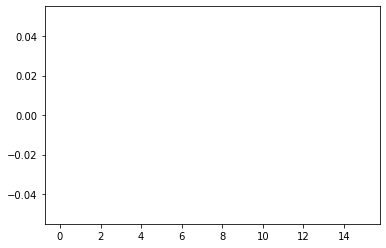

In [19]:
plt.hist(sigprob*(1.0/bkgprob),bins=15,range=(0,15))

In [20]:
R=sigprob*(1.0/bkgprob)
np.shape(R)

TensorShape([7327])

(-2.5, 7.5)

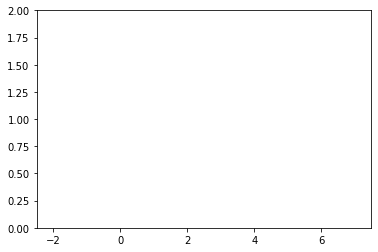

In [21]:
plt.scatter(bkglogprob,R,s=0.1)
plt.ylim(0,2)
plt.xlim(-2.5,7.5)

(array([10.,  6.,  6.,  9.,  4.,  4.,  6.,  6.,  9.,  6.]),
 array([3603.13 , 3641.773, 3680.416, 3719.059, 3757.702, 3796.345,
        3834.988, 3873.631, 3912.274, 3950.917, 3989.56 ]),
 <a list of 10 Patch objects>)

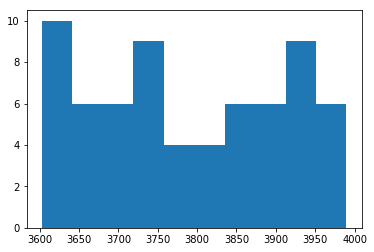

In [88]:
#cut on R
print
plt.hist(invM[~np.less(R,10)])

In [71]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

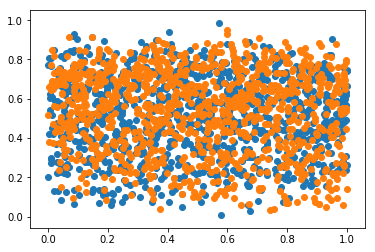

In [74]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [36]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

NameError: name 'training_data_sampled' is not defined